In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

project_path = '/content/drive/MyDrive/PH2_Project'
dataset_path = os.path.join(project_path, 'PH2Dataset')
images_root  = os.path.join(dataset_path, 'PH2 Dataset images')

print(os.listdir(images_root)[:5])



['IMD437', 'IMD434', 'IMD435', 'IMD436', 'IMD431']


In [4]:
sample_folder = sorted(os.listdir(images_root))[1]   # e.g. IMD002
sample_path = os.path.join(images_root, sample_folder)

print("Inside IMD folder:", os.listdir(sample_path))



Inside IMD folder: ['IMD003_roi', 'IMD003_lesion', 'IMD003_Dermoscopic_Image']


In [5]:
dermo_folder = [f for f in os.listdir(sample_path) if 'Dermoscopic' in f][0]
dermo_path = os.path.join(sample_path, dermo_folder)

print("Dermoscopic folder:", dermo_folder)
print("Files:", os.listdir(dermo_path))



Dermoscopic folder: IMD003_Dermoscopic_Image
Files: ['IMD003.bmp']


Image loaded: True


(np.float64(-0.5), np.float64(764.5), np.float64(573.5), np.float64(-0.5))

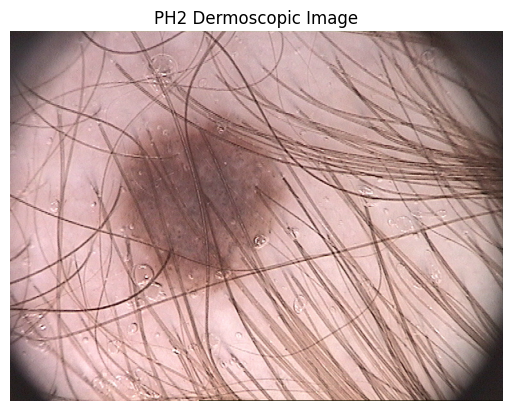

In [6]:
import cv2
import matplotlib.pyplot as plt

image_file = os.listdir(dermo_path)[0]
img_path = os.path.join(dermo_path, image_file)

img = cv2.imread(img_path)
print("Image loaded:", img is not None)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("PH2 Dermoscopic Image")
plt.axis('off')



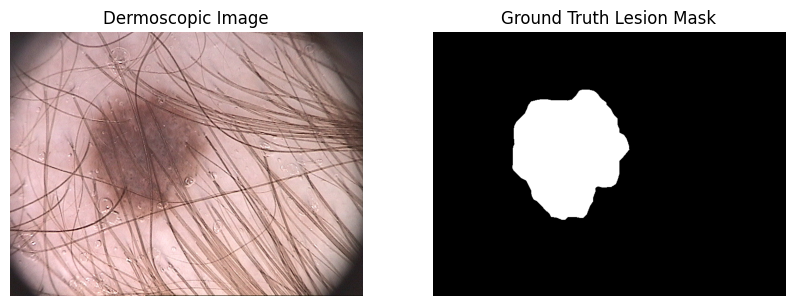

In [7]:
import os
import cv2
import matplotlib.pyplot as plt

# ---- Paths (DO NOT CHANGE) ----
project_path = '/content/drive/MyDrive/PH2_Project'
dataset_path = os.path.join(project_path, 'PH2Dataset')
images_root  = os.path.join(dataset_path, 'PH2 Dataset images')

# ---- Select any image folder (e.g., IMD002) ----
imd_folder = sorted(os.listdir(images_root))[1]   # you can change index
imd_path = os.path.join(images_root, imd_folder)

# ---- Dermoscopic image ----
dermo_folder = [f for f in os.listdir(imd_path) if 'Dermoscopic' in f][0]
dermo_path = os.path.join(imd_path, dermo_folder)
dermo_image_file = os.listdir(dermo_path)[0]

dermo_img = cv2.imread(os.path.join(dermo_path, dermo_image_file))
dermo_img = cv2.cvtColor(dermo_img, cv2.COLOR_BGR2RGB)

# ---- Lesion mask ----
lesion_folder = [f for f in os.listdir(imd_path) if 'lesion' in f.lower()][0]
lesion_path = os.path.join(imd_path, lesion_folder)
lesion_mask_file = os.listdir(lesion_path)[0]

lesion_mask = cv2.imread(os.path.join(lesion_path, lesion_mask_file), 0)

# ---- Display side by side ----
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(dermo_img)
plt.title("Dermoscopic Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(lesion_mask, cmap='gray')
plt.title("Ground Truth Lesion Mask")
plt.axis('off')

plt.show()


In [8]:
# Project paths (REDEFINE)
project_path = '/content/drive/MyDrive/PH2_Project'
dataset_path = os.path.join(project_path, 'PH2Dataset')
images_root = os.path.join(dataset_path, 'PH2 Dataset images')

# Generated masks folder (from Task-1)
generated_mask_path = os.path.join(project_path, 'Generated_Masks')


# task 2

In [9]:
# TASK 1: GENERATE CORRECT MASKS (LESION = WHITE)

import os
import cv2
import numpy as np

project_path = "/content/drive/MyDrive/PH2_Project"
images_root = os.path.join(project_path, "PH2Dataset/PH2 Dataset images")
mask_save_path = os.path.join(project_path, "Generated_Masks")

os.makedirs(mask_save_path, exist_ok=True)

for imd in sorted(os.listdir(images_root)):
    img_path = os.path.join(
        images_root, imd,
        f"{imd}_Dermoscopic_Image", f"{imd}.bmp"
    )

    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # OTSU threshold (lesion → white)
    _, mask = cv2.threshold(
        blurred, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # 🔹 Keep only the largest contour (lesion)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    clean_mask = np.zeros_like(mask)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(clean_mask, [largest], -1, 255, -1)

    cv2.imwrite(os.path.join(mask_save_path, imd + ".png"), clean_mask)

print("✅ Task 1 complete: Clean lesion masks generated")


✅ Task 1 complete: Clean lesion masks generated


In [10]:
# TASK 2: SEGMENT IMAGES (ONLY LESION VISIBLE, ALL ELSE BLACK)

import os
import cv2
import numpy as np

project_path = "/content/drive/MyDrive/PH2_Project"
images_root = os.path.join(project_path, "PH2Dataset/PH2 Dataset images")
mask_save_path = os.path.join(project_path, "Generated_Masks")

segmented_path_2 = os.path.join(project_path, "Segmented_Images_2")
os.makedirs(segmented_path_2, exist_ok=True)

for imd in sorted(os.listdir(images_root)):
    img_path = os.path.join(
        images_root, imd,
        f"{imd}_Dermoscopic_Image", f"{imd}.bmp"
    )
    mask_path = os.path.join(mask_save_path, imd + ".png")

    img = cv2.imread(img_path)
    img = cv2.resize(img, (256, 256))

    mask = cv2.imread(mask_path, 0)

    # Ensure mask is binary
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 🔹 Apply strict masking (everything else BLACK)
    segmented = np.zeros_like(img)
    segmented[mask == 255] = img[mask == 255]

    cv2.imwrite(
        os.path.join(segmented_path_2, imd + ".png"),
        segmented
    )

print("✅ Task 2 complete: Edge-blackened segmented images created")


✅ Task 2 complete: Edge-blackened segmented images created


In [11]:
import os
import cv2
import numpy as np
import pandas as pd

project_path = "/content/drive/MyDrive/PH2_Project"
segmented_path = os.path.join(project_path, "Segmented_Images_2")

features = []

for file in sorted(os.listdir(segmented_path)):
    if not file.endswith(".png"):
        continue

    img_path = os.path.join(segmented_path, file)
    img = cv2.imread(img_path)

    if img is None:
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Only lesion pixels (white area)
    lesion_pixels = gray[gray > 0]

    if len(lesion_pixels) < 100:  # skip very small/noisy masks
        continue

    row = {
        "Image_Name": file.replace(".png", ""),
        "Mean_Intensity": np.mean(lesion_pixels),
        "Std_Intensity": np.std(lesion_pixels),
        "Area": len(lesion_pixels),
        "R_Mean": np.mean(img[:,:,0][gray > 0]),
        "G_Mean": np.mean(img[:,:,1][gray > 0]),
        "B_Mean": np.mean(img[:,:,2][gray > 0]),
        "Target": ""   # EMPTY – you will fill later
    }

    features.append(row)

df = pd.DataFrame(features)

# 🔹 NEW FILE NAME
save_path = os.path.join(project_path, "Feature_Extracted_V2.xlsx")
df.to_excel(save_path, index=False)

print("✅ Feature_Extracted_V2.xlsx created")
print(df.head())
print("Total samples:", len(df))



✅ Feature_Extracted_V2.xlsx created
  Image_Name  Mean_Intensity  Std_Intensity   Area     R_Mean      G_Mean  \
0     IMD002       93.785055      20.737879  15925  51.636860   79.225495   
1     IMD003      110.687893      21.542607   7632  94.868187   98.982966   
2     IMD004      105.309729      28.026281  13105  85.887600   92.659443   
3     IMD006      125.405712      13.404073   5637  85.684052  112.638105   
4     IMD008      136.007053      22.149814   2694  79.853378  123.773571   

       B_Mean Target  
0  138.430895         
1  139.694313         
2  137.538955         
3  165.622317         
4  181.440609         
Total samples: 200


In [14]:
print(project_path)
print(os.path.exists(project_path))


/content/drive/MyDrive/PH2_Project
True


In [15]:
print("Files inside project folder:")
print(os.listdir(project_path))


Files inside project folder:
['PH2Dataset', 'PH2_Features.xlsx', 'Generated_Masks', 'Segmented_Images', 'Feature_Extracted.xlsx', 'ph_Model.pkl', 'KFold_Model.pkl', 'ph_Model.joblib', 'KFold_Model.joblib', 'Segmented_Images_2', 'Feature_Extracted_V2.xlsx']


In [16]:
import pandas as pd
df=pd.read_excel(os.path.join(project_path, "Feature_Extracted_V2.xlsx"))

In [ ]:
df

,Image_Name,Mean_Intensity,Std_Intensity,Area,R_Mean,G_Mean,B_Mean,Target
0,IMD002,92.474696,22.688562,20491,56.578059,79.930506,130.783612,0
1,IMD003,102.052689,32.970697,17423,90.064340,93.708718,122.998737,0
2,IMD004,103.628195,31.251869,18117,87.326434,93.087045,130.527350,0
3,IMD006,108.227250,27.451862,12132,82.464392,98.707550,136.738625,0
4,IMD008,114.532063,32.223080,8187,91.391719,108.132405,135.918285,0
...,...,...,...,...,...,...,...,...
195,IMD433,126.746960,29.361869,10856,85.956245,114.058401,167.211404,0
196,IMD434,106.470357,22.518460,14759,93.620774,93.741852,136.355309,0
197,IMD435,132.792167,24.511087,31583,121.481715,114.151411,173.660862,1
198,IMD436,130.802825,24.496490,32783,84.688802,116.219809,177.009029,0


In [17]:
df.dtypes

,0
Image_Name,object
Mean_Intensity,float64
Std_Intensity,float64
Area,int64
R_Mean,float64
G_Mean,float64
B_Mean,float64
Target,int64


In [18]:
import pandas as pd
import os

# Ensure project_path is defined, if not already in session
# project_path = '/content/drive/MyDrive/PH2_Project'

# Re-load the DataFrame to ensure we have the latest data from the Excel file
save_path = os.path.join(project_path, "Feature_Extracted_V2.xlsx")
df = pd.read_excel(save_path)

print("DataFrame re-loaded successfully.")
print(df.head())

DataFrame re-loaded successfully.
  Image_Name  Mean_Intensity  Std_Intensity   Area     R_Mean      G_Mean  \
0     IMD002       93.785055      20.737879  15925  51.636860   79.225495   
1     IMD003      110.687893      21.542607   7632  94.868187   98.982966   
2     IMD004      105.309729      28.026281  13105  85.887600   92.659443   
3     IMD006      125.405712      13.404073   5637  85.684052  112.638105   
4     IMD008      136.007053      22.149814   2694  79.853378  123.773571   

       B_Mean  Target  
0  138.430895       0  
1  139.694313       0  
2  137.538955       0  
3  165.622317       0  
4  181.440609       0  


In [ ]:
# Convert 'Target' column to integer type
df['Target'] = df['Target'].astype(int)

print("Data type of 'Target' column converted to int.")
print(df.dtypes)

Data type of 'Target' column converted to int.
Image_Name         object
Mean_Intensity    float64
Std_Intensity     float64
Area                int64
R_Mean            float64
G_Mean            float64
B_Mean            float64
Target              int64
dtype: object


In [19]:
print(df.isna().sum())


Image_Name        0
Mean_Intensity    0
Std_Intensity     0
Area              0
R_Mean            0
G_Mean            0
B_Mean            0
Target            0
dtype: int64


In [20]:
print(df.dtypes)


Image_Name         object
Mean_Intensity    float64
Std_Intensity     float64
Area                int64
R_Mean            float64
G_Mean            float64
B_Mean            float64
Target              int64
dtype: object


In [21]:
print(df['Target'].unique())


[0 1]


In [22]:
# LOAD DATASET & PREPARE ML DATA

# Once Target is filled:

import pandas as pd
import numpy as np

project_path = "/content/drive/MyDrive/PH2_Project"
df = pd.read_excel(project_path + "/Feature_Extracted_V2.xlsx")

# Convert Target to numeric
df["Target"] = df["Target"].astype(int)

X = df.drop(columns=["Image_Name", "Target"])
y = df["Target"]

print("Class distribution:")
print(y.value_counts())

Class distribution:
Target
0    161
1     39
Name: count, dtype: int64


In [23]:
# STEP 3: TRAIN–TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [24]:
# STEP 4: RANDOM FOREST TRAINING
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [25]:
# STEP 5: PREDICTION & EVALUATION METRICS
# ✅ YES — confusion matrix can (and should) be made for ALL test images
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
sens = recall_score(y_test, y_pred)  # sensitivity (recall for melanoma)
spec = cm[0,0] / (cm[0,0] + cm[0,1])

print("Confusion Matrix:\n", cm)
print("Accuracy:", acc)
print("Sensitivity (Melanoma Recall):", sens)
print("Specificity:", spec)

Confusion Matrix:
 [[31  1]
 [ 4  4]]
Accuracy: 0.875
Sensitivity (Melanoma Recall): 0.5
Specificity: 0.96875


# **Interpretation:**

- Accuracy → overall correctness

- Sensitivity → how well melanoma is detected

- Specificity → how well non-melanoma is detected

In [26]:
# CONFUSION MATRIX FOR ALL IMAGES


y_all_pred = rf_model.predict(X)

cm_all = confusion_matrix(y, y_all_pred)
print("Confusion Matrix (All Images):\n", cm_all)

Confusion Matrix (All Images):
 [[160   1]
 [  4  35]]


In [28]:
# STEP 7: SAVE MODEL (JOBLIB – BEST PRACTICE)
import joblib

joblib.dump(rf_model, project_path + "/RF_Model_V2.joblib")
print("✅ RF_Model_V2.joblib saved")

✅ RF_Model_V2.joblib saved


# Training Random Forest Model

In [ ]:
# IMPORT LIBRARIES


import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [ ]:
# LOAD FEATURE DATASET
project_path = "/content/drive/MyDrive/PH2_Project"

df = pd.read_excel(project_path + "/Feature_Extracted.xlsx")

print(df.shape)
print(df.head())

(200, 8)
  Image_Name  Mean_Intensity  Std_Intensity   Area     R_Mean      G_Mean  \
0     IMD002       92.474696      22.688562  20491  56.578059   79.930506   
1     IMD003      102.052689      32.970697  17423  90.064340   93.708718   
2     IMD004      103.628195      31.251869  18117  87.326434   93.087045   
3     IMD006      108.227250      27.451862  12132  82.464392   98.707550   
4     IMD008      114.532063      32.223080   8187  91.391719  108.132405   

       B_Mean  Target  
0  130.783612       0  
1  122.998737       0  
2  130.527350       0  
3  136.738625       0  
4  135.918285       0  


In [ ]:
# SPLIT FEATURES & TARGET
X = df.drop(columns=['Image_Name', 'Target'])
y = df['Target']

In [ ]:
# TRAIN-TEST SPLIT (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# TRAIN RANDOM FOREST
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# PREDICTION
y_pred = model.predict(X_test)

In [ ]:
# CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[31  1]
 [ 3  5]]


In [ ]:
# EVALUATION METRICS
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)   # Recall of class 1 (melanoma)
specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print("Accuracy:", accuracy)
print("Sensitivity (Recall):", sensitivity)
print("Specificity:", specificity)

Accuracy: 0.9
Sensitivity (Recall): 0.625
Specificity: 0.96875


In [ ]:
import pickle
import os

# Define the path to save the model
model_save_path = os.path.join(project_path, "ph_Model.pkl")

# Save the trained model
with open(model_save_path, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/MyDrive/PH2_Project/ph_Model.pkl


# K-Fold Cross Validation Model

In [ ]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# -----------------------------
# Load dataset
# -----------------------------
project_path = "/content/drive/MyDrive/PH2_Project"
df = pd.read_excel(project_path + "/Feature_Extracted.xlsx")

X = df.drop(columns=['Image_Name', 'Target'])
y = df['Target']

# -----------------------------
# K-Fold setup
# -----------------------------
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

acc_list, sens_list, spec_list = [], [], []

print("===== K-FOLD TRAINING =====")

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"\nFold {fold+1}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred)
    spec = cm[0,0] / (cm[0,0] + cm[0,1])

    print("Confusion Matrix:\n", cm)
    print("Accuracy:", acc)
    print("Sensitivity:", sens)
    print("Specificity:", spec)

    acc_list.append(acc)
    sens_list.append(sens)
    spec_list.append(spec)

# -----------------------------
# Average results
# -----------------------------
print("\n===== AVERAGE K-FOLD RESULTS =====")
print("Average Accuracy:", np.mean(acc_list))
print("Average Sensitivity:", np.mean(sens_list))
print("Average Specificity:", np.mean(spec_list))

# -----------------------------
# Train FINAL K-FOLD model on FULL data
# -----------------------------
final_kfold_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

final_kfold_model.fit(X, y)

# Save model
with open(project_path + "/KFold_Model.pkl", "wb") as f:
    pickle.dump(final_kfold_model, f)

print("KFold_Model.pkl saved")


===== K-FOLD TRAINING =====

Fold 1
Confusion Matrix:
 [[30  3]
 [ 4  3]]
Accuracy: 0.825
Sensitivity: 0.42857142857142855
Specificity: 0.9090909090909091

Fold 2
Confusion Matrix:
 [[31  1]
 [ 2  6]]
Accuracy: 0.925
Sensitivity: 0.75
Specificity: 0.96875

Fold 3
Confusion Matrix:
 [[30  2]
 [ 3  5]]
Accuracy: 0.875
Sensitivity: 0.625
Specificity: 0.9375

Fold 4
Confusion Matrix:
 [[30  2]
 [ 4  4]]
Accuracy: 0.85
Sensitivity: 0.5
Specificity: 0.9375

Fold 5
Confusion Matrix:
 [[31  1]
 [ 4  4]]
Accuracy: 0.875
Sensitivity: 0.5
Specificity: 0.96875

===== AVERAGE K-FOLD RESULTS =====
Average Accuracy: 0.8699999999999999
Average Sensitivity: 0.5607142857142857
Average Specificity: 0.9443181818181818
KFold_Model.pkl saved
